In [ ]:
!pip install transformers datasets --quiet

In [ ]:
import json
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
def load_data(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return Dataset.from_list(data)

train_dataset = load_data("/content/train.json")
val_dataset = load_data("/content/val.json")
test_dataset = load_data("/content/test.json")


In [ ]:
label_map = {"SUPPORTS": 0, "REFUTES": 1}


In [ ]:
model_checkpoint = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess(example):
    # Tránh input quá dài
    text = f"{example['claim']}</s>{example['evidence']}"
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=256,
    )
    encoding["label"] = label_map[example["label"]]
    return encoding

train_tokenized = train_dataset.map(preprocess)
val_tokenized = val_dataset.map(preprocess)
test_tokenized = test_dataset.map(preprocess)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/9665 [00:00<?, ? examples/s]

Map:   0%|          | 0/1208 [00:00<?, ? examples/s]

Map:   0%|          | 0/1209 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at VietAI/vit5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./vit5_classify_output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    logging_strategy="steps",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)


In [ ]:
def compute_metrics(pred):
    logits = pred.predictions
    if isinstance(logits, tuple):
        logits = logits[0]  # lấy logits nếu là tuple (logits, ...)
    preds = logits.argmax(-1)

    return {
        "accuracy": accuracy_score(pred.label_ids, preds),
        "f1": f1_score(pred.label_ids, preds, average="macro"),
        "precision": precision_score(pred.label_ids, preds, average="macro"),
        "recall": recall_score(pred.label_ids, preds, average="macro")
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-9-a246b8a9033e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: 22520061 (21522798-uit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.355200,0.353948,0.901490,0.900620,0.899738,0.901868
2,0.161200,0.395502,0.917219,0.916736,0.915644,0.919674
3,0.111100,0.484667,0.922185,0.921770,0.920747,0.925059


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].


TrainOutput(global_step=3627, training_loss=0.3126857025681825, metrics={'train_runtime': 3452.1222, 'train_samples_per_second': 8.399, 'train_steps_per_second': 1.051, 'total_flos': 8854738309555200.0, 'train_loss': 0.3126857025681825, 'epoch': 3.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/Finetune/saved_vit5_classify")
tokenizer.save_pretrained("/content/drive/MyDrive/Finetune/saved_vit5_classify")

('/content/drive/MyDrive/Finetune/saved_vit5_classify/tokenizer_config.json',
 '/content/drive/MyDrive/Finetune/saved_vit5_classify/special_tokens_map.json',
 '/content/drive/MyDrive/Finetune/saved_vit5_classify/spiece.model',
 '/content/drive/MyDrive/Finetune/saved_vit5_classify/added_tokens.json',
 '/content/drive/MyDrive/Finetune/saved_vit5_classify/tokenizer.json')

In [ ]:
val_results = trainer.evaluate()
print("Validation results:", val_results)


Validation results: {'eval_loss': 0.4846671521663666, 'eval_accuracy': 0.9221854304635762, 'eval_f1': 0.9217702821869489, 'eval_precision': 0.9207465542278479, 'eval_recall': 0.9250591390245458, 'eval_runtime': 43.0832, 'eval_samples_per_second': 28.039, 'eval_steps_per_second': 3.505, 'epoch': 3.0}


In [ ]:
test_results = trainer.predict(test_tokenized)
# Access the first element of the predictions tuple before calling argmax
# This line is correct for getting the predicted labels from the PredictionOutput object
test_preds = test_results.predictions[0].argmax(axis=-1)
# Pass the PredictionOutput object directly to compute_metrics
test_metrics = compute_metrics(test_results)
print("Test metrics:", test_metrics)

Test metrics: {'accuracy': 0.9230769230769231, 'f1': 0.9224348277191823, 'precision': 0.9213721659696237, 'recall': 0.924067510314845}


🔍 Đang đánh giá trên tập test...



=== Báo cáo phân loại ===
              precision    recall  f1-score   support

    SUPPORTS     0.9445    0.9149    0.9295       670
     REFUTES     0.8982    0.9332    0.9154       539

    accuracy                         0.9231      1209
   macro avg     0.9214    0.9241    0.9224      1209
weighted avg     0.9239    0.9231    0.9232      1209



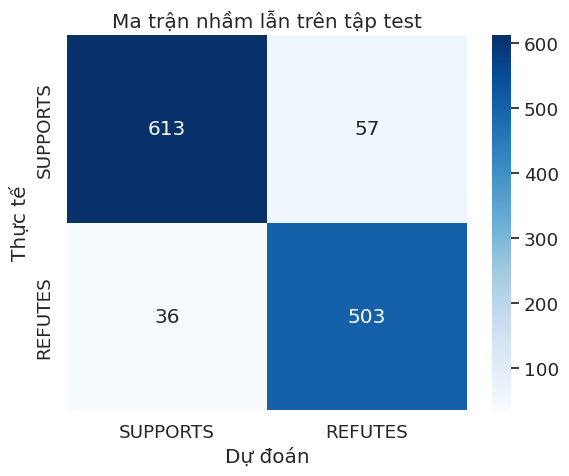

In [ ]:
# %%
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_on_testset(trainer, test_dataset, label_names=["SUPPORTS", "REFUTES"]):
    print("🔍 Đang đánh giá trên tập test...")

    # Use the tokenized test dataset instead of the original
    predictions = trainer.predict(test_dataset)
    y_true = predictions.label_ids
    # Access the first element of the predictions tuple before calling argmax
    # Nếu predictions.predictions là một tuple, lấy phần tử đầu tiên chứa logits
    if isinstance(predictions.predictions, tuple):
        logits = predictions.predictions[0]
    else:
        logits = predictions.predictions

    y_pred = np.argmax(logits, axis=1)


    # In báo cáo phân loại
    print("\n=== Báo cáo phân loại ===")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)

    # Vẽ biểu đồ
    plt.figure(figsize=(6, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title("Ma trận nhầm lẫn trên tập test")
    plt.tight_layout()
    plt.show()

# %%
# Pass the tokenized test dataset to the evaluation function
evaluate_on_testset(trainer, test_tokenized, label_names=["SUPPORTS", "REFUTES"])